# ECG/Resp Inspection
Processes ECG data (from files or from ICE parameters in the TWIX file) and displays time-domain plots with optionally detected events (R-peaks). Also plots respiratory signals and detects peaks/troughs for respiration.

### Loading packages and data

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import utils.data_ingestion as di
import utils.ecg_resp as ecg_resp
import scipy.signal as signal
# %matplotlib widget

def load_config(config_file="config.yaml"):
    """
    Load configuration from a YAML file.

    Parameters
    ----------
    config_file : str
        Path to the YAML configuration file.

    Returns
    -------
    dict
        Parsed configuration.
    """
    with open(config_file, "r") as f:
        return yaml.safe_load(f)

# Read config
config = load_config()

# Paths and optional file references
twix_file = config["data"]["twix_file"]
dicom_folder = config["data"]["dicom_folder"]
ecg_files = config["data"].get("ecg_files", None)
event_file = config["data"].get("event_file", None)
resp_file = config["data"].get("resp_file", None)

# Read TWIX, extract raw k-space, and derive sampling frequency
scans = di.read_twix_file(twix_file, include_scans=[-1], parse_pmu=False)

Software version: VD/VE (!?)

Scan  1


100%|██████████| 287M/287M [00:00<00:00, 860MB/s] 

Read 1 scans from 20250307_JM/raw/meas_MID00115_FID27380_Cor_250306_2.dat


### Extracting and analyzing ECG

In [2]:
kspace = di.extract_image_data(scans)

framerate, frametime = di.get_dicom_framerate(dicom_folder)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]
fs = framerate * n_phase_encodes_per_frame  # ECG / respiration sampling freq

# Load ECG data either from external files or from the ICE parameters
if ecg_files:
    # Concatenate multi-file ECG data channel-wise
    ecg_data = []
    for ecg_file in ecg_files:
        raw_ecg = np.loadtxt(ecg_file, skiprows=1, usecols=1)
        ecg_data.append(signal.resample(raw_ecg, kspace.shape[0]))
    ecg_data = np.vstack(ecg_data).T
else:
    ecg_columns = np.s_[18:21]
    ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
    # Force 2D shape
    if ecg_data.ndim == 1:
        ecg_data = ecg_data.reshape(-1, 1)

Extracted image data shape: (4800, 30, 256)


In [3]:
# Example (commented) R-peak detection
# r_peaks_list = ecg_resp.detect_r_peaks(ecg_data, fs)
# hr = ecg_resp.compute_average_heart_rate(r_peaks_list, fs)
# print(f"Average heart rate: {hr:.2f} BPM")

# If event_file is present, interpret it as R-peak triggers or some other event
if event_file:
    resampled_length = kspace.shape[0]
    raw_events = np.loadtxt(event_file, skiprows=1, usecols=1)
    # Normalize events so that non-zero remain as spikes
    raw_events = raw_events - np.min(raw_events)
    raw_length = len(raw_events)

    # Create empty, then place spikes based on global fraction
    resampled_events = np.zeros(resampled_length)
    raw_spike_indices = np.nonzero(raw_events)[0]
    resampled_spike_indices = np.round(
        raw_spike_indices / (raw_length - 1) * (resampled_length - 1)
    ).astype(int)

    for (raw_idx, resampled_idx) in zip(raw_spike_indices, resampled_spike_indices):
        resampled_events[resampled_idx] = raw_events[raw_idx]
else:
    resampled_events = None

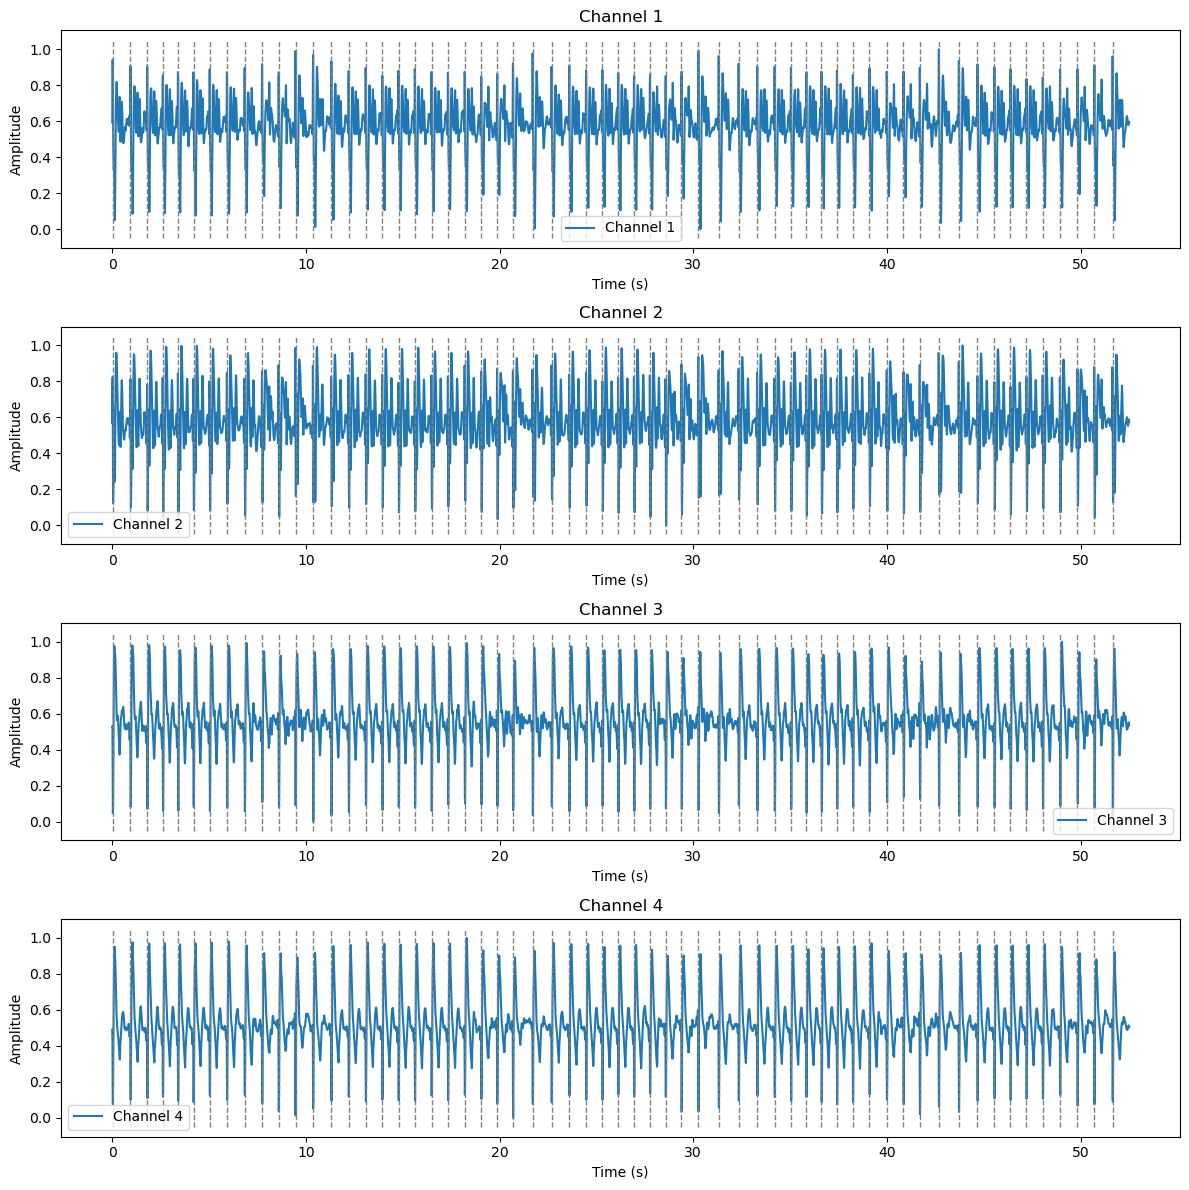

In [4]:
# Normalize ECG
ecg_data = (ecg_data - np.min(ecg_data, axis=0)) / (
    np.ptp(ecg_data, axis=0) + 1e-9
)

# Plot ECG with optional event spikes as vertical lines
ecg_resp.plot_ecg_signals(ecg_data, fs, spike_indices=np.nonzero(resampled_events)[0] if resampled_events is not None else None, mode="separate")

### Extracting and analyzing resp

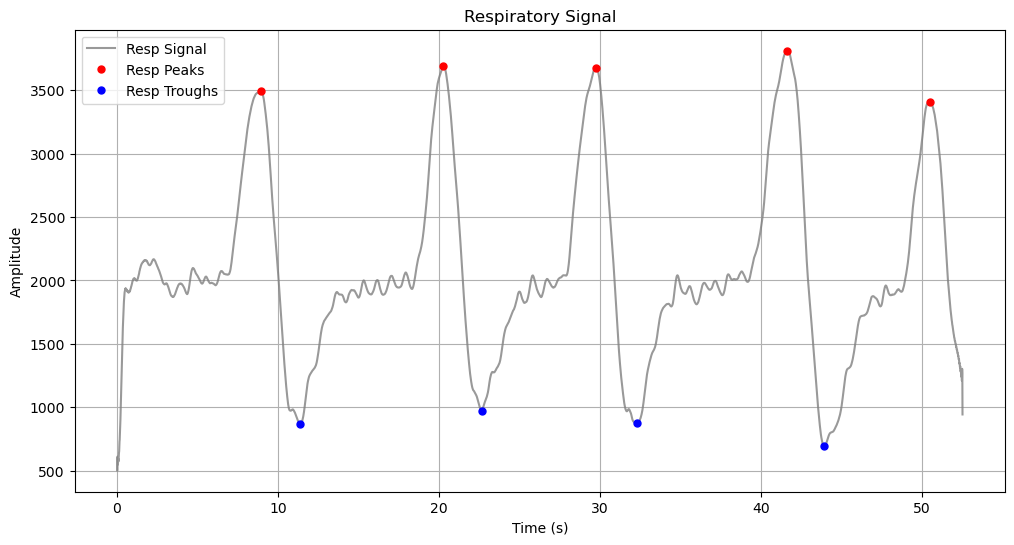

In [5]:
# If a respiratory file is present, load and detect peaks/troughs
if resp_file:
    resp_data = np.loadtxt(resp_file, skiprows=1, usecols=1)
    # Resample to match the total number of k-space time points
    resp_data = signal.resample(resp_data, kspace.shape[0])[:, np.newaxis]

    resp_peaks = ecg_resp.detect_resp_peaks(resp_data, fs, method='scipy', height=0.6, prominence=0.2)
    resp_troughs = ecg_resp.detect_resp_peaks(-resp_data, fs, method='scipy', height=0.6, prominence=0.2)

    # Plot
    ecg_resp.plot_resp_signal(resp_data, fs, resp_peaks=resp_peaks, resp_troughs=resp_troughs)